In [ ]:
#importing modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
#using drive function to link data stored in google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Housing prices/housing.csv")

In [ ]:
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [ ]:
data=data.drop(["ocean_proximity"],axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [ ]:
#cleaning the data - rather than deleting the rows with null values, I replaced it with interpolation method
data['total_bedrooms'] = data['total_bedrooms'].interpolate().astype('float64') 
#just using interpolate resulted in change in datatype of that particular column
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20640 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


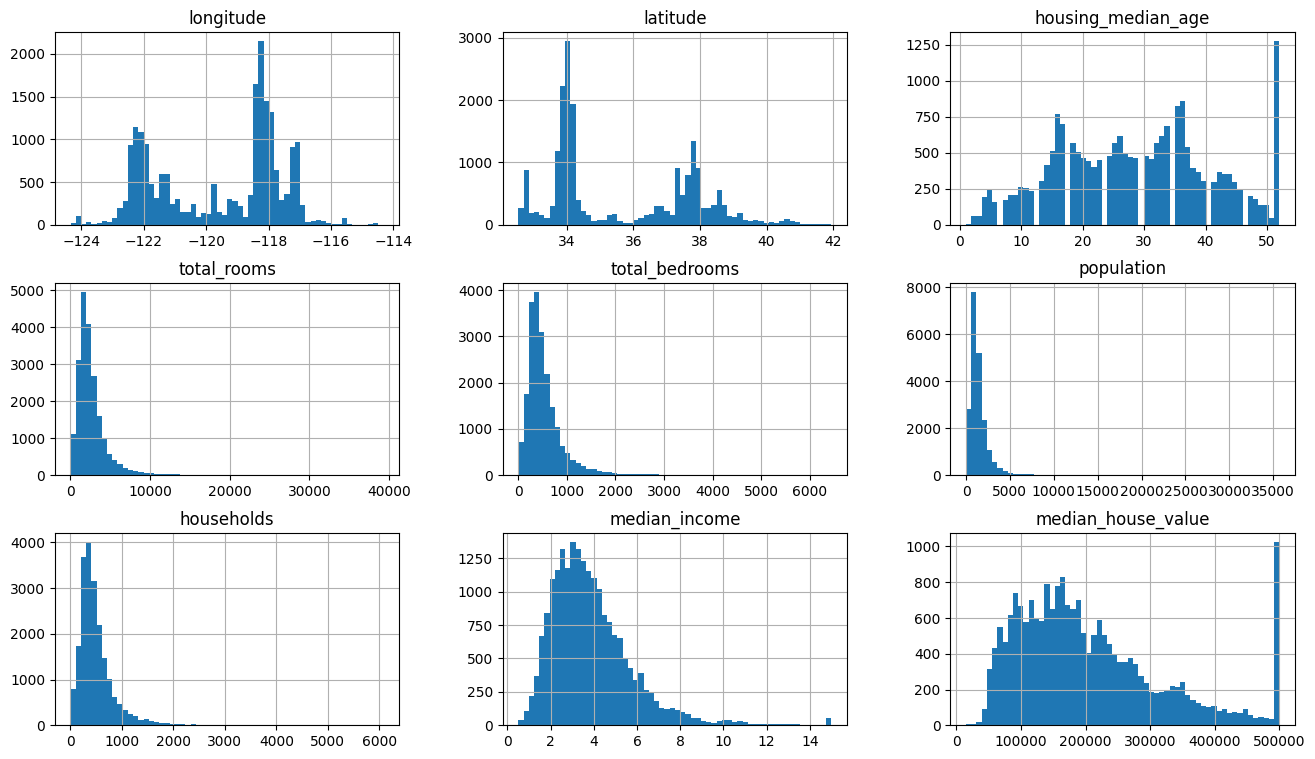

In [ ]:
data.hist(bins=60,figsize=(16,9));plt.show()

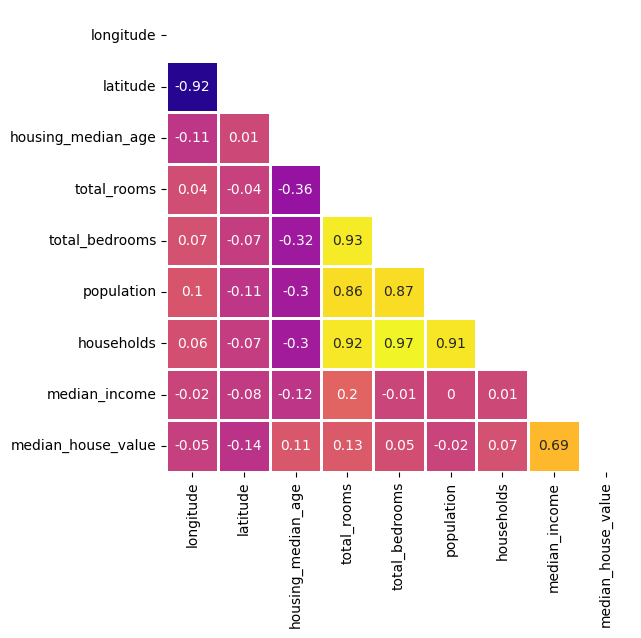

In [ ]:
#defining correlation matrix in order to find relation b/w each feature with other
'''
one thing to remember :
don't select/deselect features just on basis of correlation matrix,
feature knowledge and model performance to be taken care as well
'''
def corrMat(df,id=False):
    
    corr_mat = df.corr().round(2)
    f, ax = plt.subplots(figsize=(6,6))
    mask = np.zeros_like(corr_mat,dtype=bool)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr_mat,mask=mask,vmin=-1,vmax=1,center=0, 
                cmap='plasma',square=False,lw=2,annot=True,cbar=False);plt.show()  
corrMat(data)

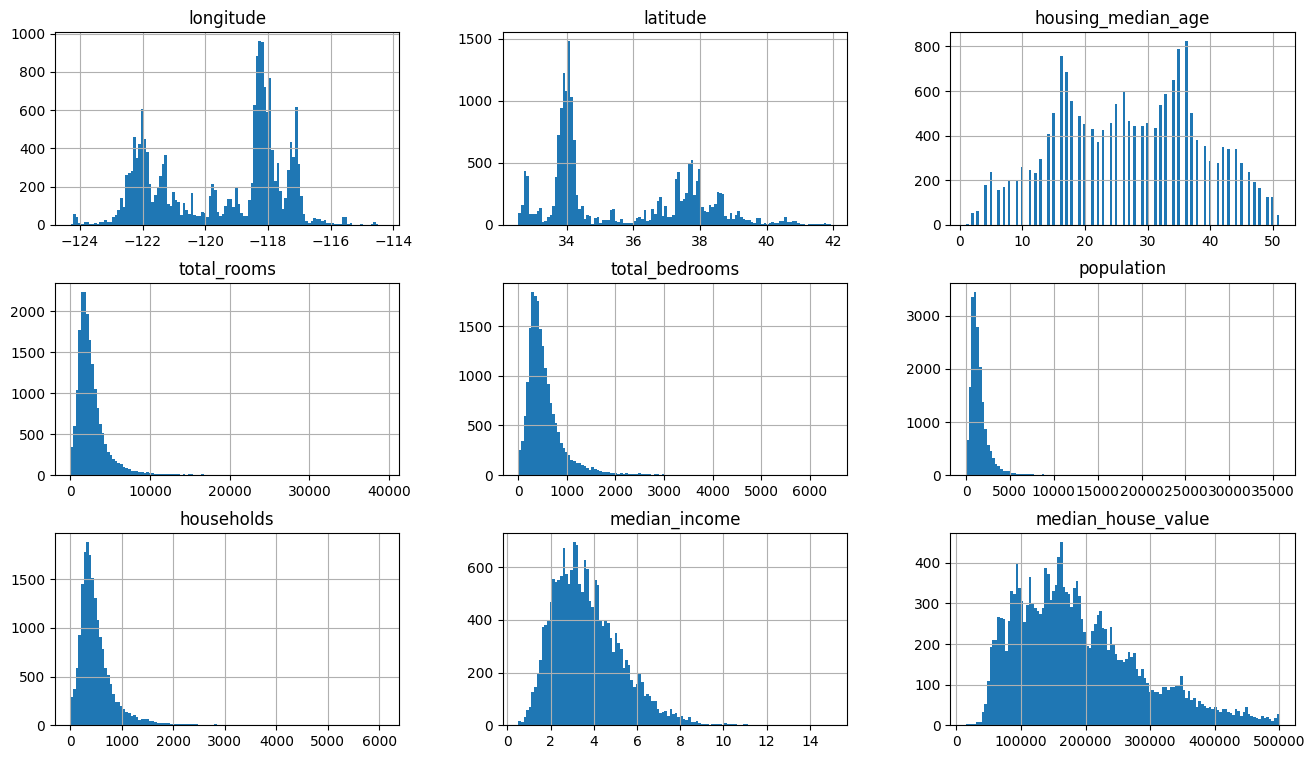

In [ ]:
#removing outliers in median_house_value & housing_median_age, simply by aquiring the max value of that column and not including it in new dataset
max_val=data["median_house_value"].max()
new_data=data[data["median_house_value"]!=max_val]

max_val=new_data["housing_median_age"].max()
new_data=new_data[new_data["housing_median_age"]!=max_val]
new_data.hist(bins=120,figsize=(16,9));plt.show()

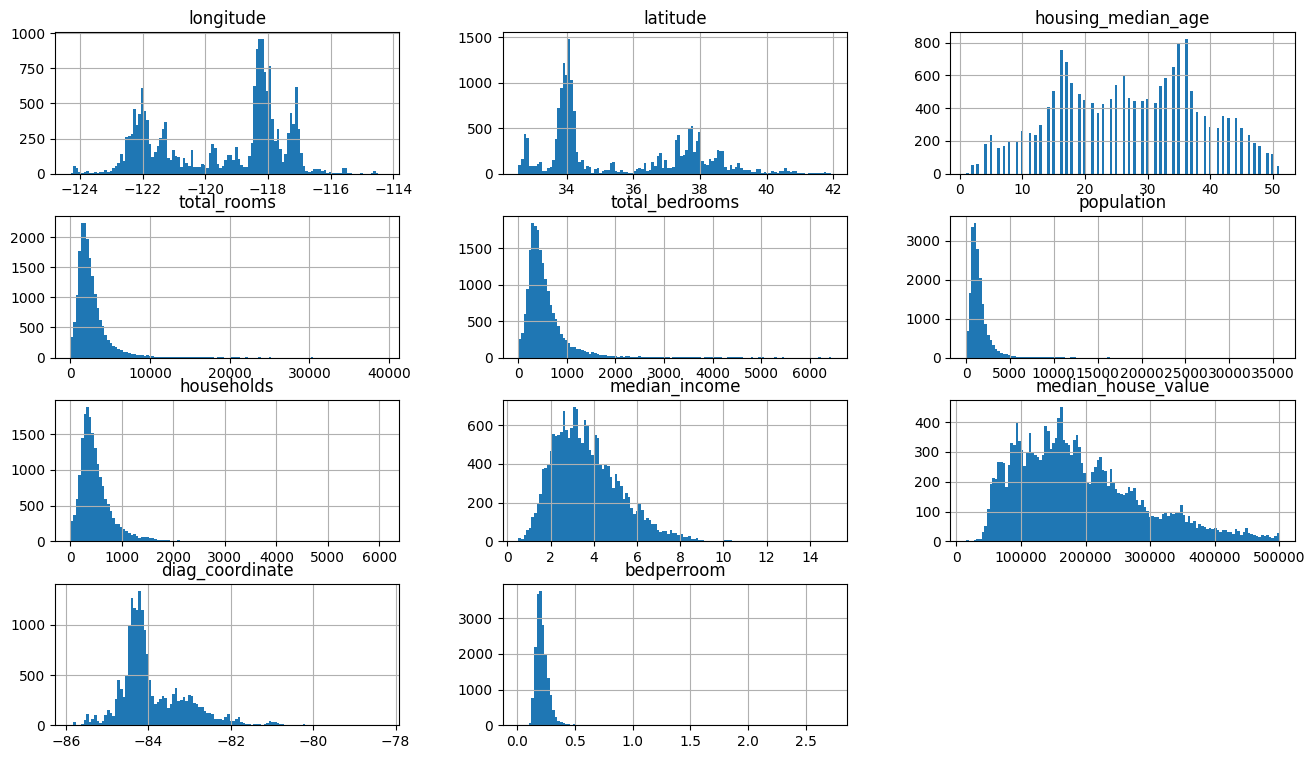

In [ ]:
#adding new data to the dataset for better training of model
new_data["diag_coordinate"]=new_data["longitude"]+new_data["latitude"]
new_data["bedperroom"]=new_data["total_bedrooms"]/new_data["total_rooms"]
new_data.hist(bins=120,figsize=(16,9))
plt.show()

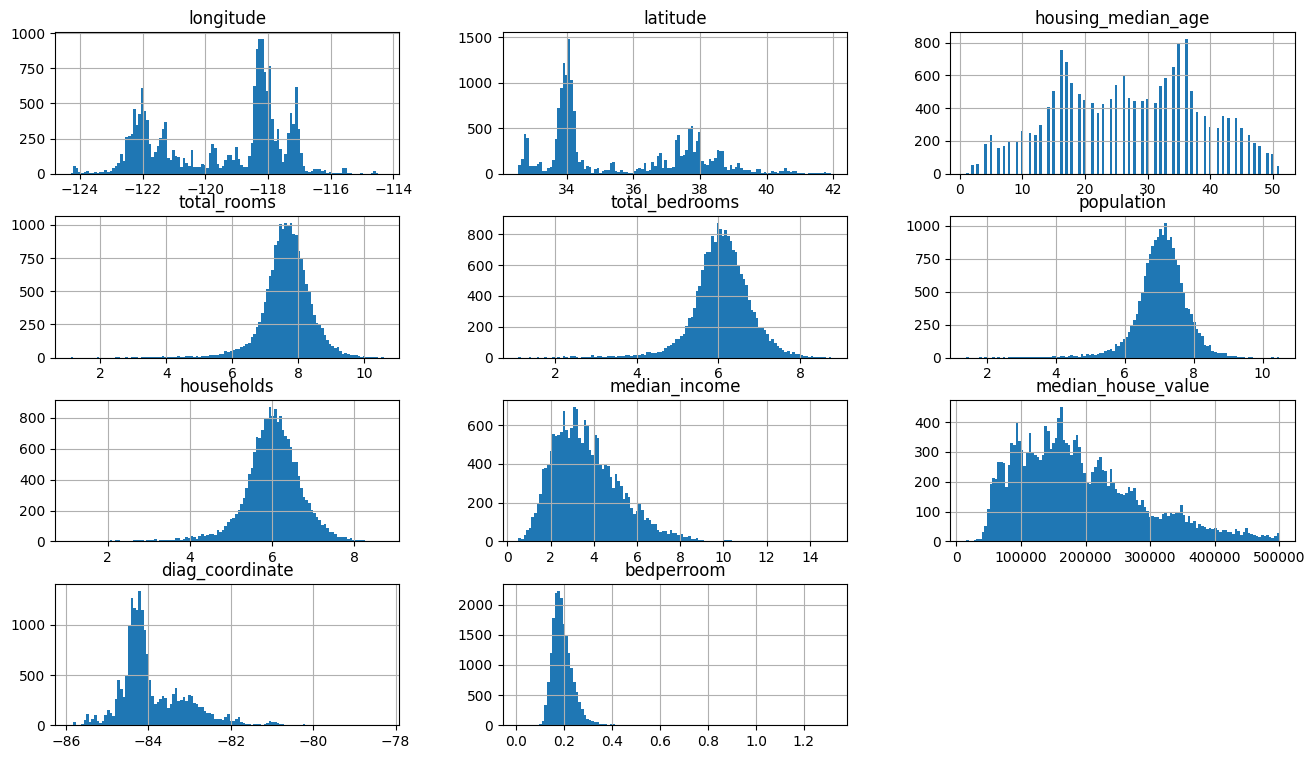

In [ ]:
#since the above hist graphs for these were leftskewed 
#and +1 if zero values exits (since log(1) is not defined)
new_data["total_rooms"]=np.log(new_data["total_rooms"] +1) 
new_data["total_bedrooms"]=np.log(new_data["total_bedrooms"] +1)
new_data["population"]=np.log(new_data["population"] +1)
new_data["households"]=np.log(new_data["households"] +1)
new_data["bedperroom"]=np.log(new_data["bedperroom"] +1)

new_data.hist(bins=120,figsize=(16,9))
plt.show()

In [ ]:
#separating the data in input and output format
X,Y=new_data.drop(['median_house_value'],axis=1) , new_data['median_house_value']

In [ ]:
#normalizing the input features of dataset
x_norm=(X-X.mean())/X.std()
x_norm.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,diag_coordinate,bedperroom
0,-1.385794,1.064747,1.226065,-1.168351,-1.693250,-1.763651,-1.618343,2.950195,-0.553604,-1.189661
1,-1.380746,1.055434,-0.523438,1.657103,1.305836,0.995347,1.439106,2.935036,-0.565684,-1.021719
8,-1.400939,1.046122,1.313541,0.273818,0.594359,0.049056,0.536436,-1.027271,-0.638161,0.795735
15,-1.400939,1.050778,2.013342,-0.842154,-0.599066,-0.704048,-0.593196,-0.998865,-0.626081,0.668780
18,-1.400939,1.046122,2.013342,0.095138,0.063962,-0.222084,0.048651,-1.084149,-0.638161,-0.177293


In [ ]:
Y.head()

0     452600.0
1     358500.0
8     226700.0
15    140000.0
18    158700.0
Name: median_house_value, dtype: float64

In [ ]:
#converting pandas series to pandas dataframe
y_norm=Y.to_frame()
y_norm=(y_norm-y_norm.mean())/y_norm.std()
y_norm.head()

,median_house_value
0,2.745503
1,1.763148
8,0.387225
15,-0.517877
18,-0.322659


In [ ]:
#splitting the dataset into training and testing set
x_train,x_test,y_train,y_test=train_test_split(x_norm,y_norm,test_size=0.2,random_state=0)

In [ ]:
#declaring a polynomial model
poly_model=PolynomialFeatures(degree=4)
poly_x_train=poly_model.fit_transform(x_train)
poly_model.fit(poly_x_train,y_train)
regression_model=LinearRegression()
regression_model.fit(poly_x_train,y_train)

#predicting using regression model
poly_x_test=poly_model.fit_transform(x_test)
y_pred=regression_model.predict(poly_x_test)
regression_model.coef_
mean_squared_error(y_test,y_pred,squared=False)

3.4164764575484114

[]

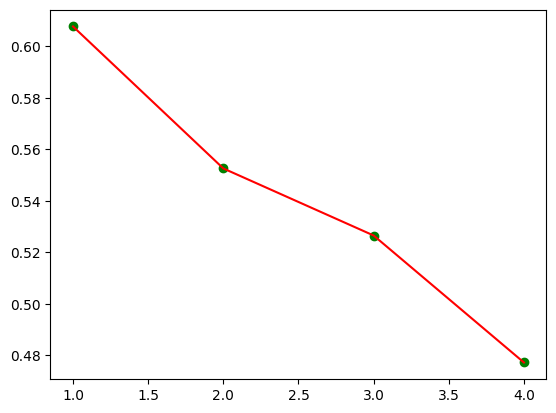

In [ ]:
#using multiple degree polynomials to check which fits the data the best
total_degrees=[1,2,3,4]
plt_mean_squared_error=[]

for degri in total_degrees:
  poly_model=PolynomialFeatures(degree=degri)

  poly_x_train=poly_model.fit_transform(x_train)
  poly_model.fit(poly_x_train,y_train)

  regression_model=LinearRegression()
  regression_model.fit(poly_x_train,y_train)
  y_pred=regression_model.predict(poly_x_train)
  plt_mean_squared_error.append(mean_squared_error(y_train,y_pred,squared=False))

plt.scatter(total_degrees,plt_mean_squared_error, color="green")
plt.plot(total_degrees,plt_mean_squared_error, color="red")
plt.plot()

In [ ]:
poly_x_test=poly_model.fit_transform(x_test)
y_pred=regression_model.predict(poly_x_test)
regression_model.coef_
mean_squared_error(y_test,y_pred,squared=False)

3.4164764575484114

In [ ]:
#Fatest_poly=poly_reg.fit_transform(x_test)
#(pol_reg.predict(test_poly)-y_test).mean()

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import regularizers

In [ ]:
# Split data into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(x_norm,y_norm,test_size=0.2,random_state=0)
# Normalize the data
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)


In [ ]:
# Define the neural network architecture
model = keras.Sequential([
    keras.layers.Dense(256, activation='relu',kernel_regularizer=regularizers.l1(0.001), input_shape=[train_data.shape[1]]),
    keras.layers.Dense(256, kernel_regularizer=regularizers.l1(0.001), activation='relu'),
    keras.layers.Dense(128, kernel_regularizer=regularizers.l1(0.001), activation='relu'),
    keras.layers.Dense(64, kernel_regularizer=regularizers.l1(0.001), activation='relu'),
    keras.layers.Dense(1)
])


In [ ]:
# Compile the model
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mean_absolute_error'])


In [ ]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=20)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

history = model.fit(train_data, train_labels,batch_size=64, epochs=500,validation_data=(test_data,test_labels), callbacks=[early_stopping])

Epoch 1/500
233/233 [==============================] - 4s 9ms/step - loss: 2.5773 - mean_absolute_error: 0.5055 - val_loss: 1.2555 - val_mean_absolute_error: 0.4541
Epoch 2/500
233/233 [==============================] - 1s 5ms/step - loss: 1.0296 - mean_absolute_error: 0.4613 - val_loss: 0.8800 - val_mean_absolute_error: 0.4355
Epoch 3/500
233/233 [==============================] - 1s 6ms/step - loss: 0.8047 - mean_absolute_error: 0.4562 - val_loss: 0.7138 - val_mean_absolute_error: 0.4418
Epoch 4/500
233/233 [==============================] - 1s 5ms/step - loss: 0.6859 - mean_absolute_error: 0.4452 - val_loss: 0.6571 - val_mean_absolute_error: 0.4299
Epoch 5/500
233/233 [==============================] - 1s 5ms/step - loss: 0.6238 - mean_absolute_error: 0.4442 - val_loss: 0.6157 - val_mean_absolute_error: 0.4841
Epoch 6/500
233/233 [==============================] - 1s 6ms/step - loss: 0.5760 - mean_absolute_error: 0.4364 - val_loss: 0.5444 - val_mean_absolute_error: 0.4237
Epoch 7/50